In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torch.utils.data as data
from PIL import Image
from sklearn.metrics import confusion_matrix
from tensorboardX import SummaryWriter
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
% matplotlib inline
import time
import os
import copy
DATADIR = '/home/jack/Desktop/Datasets/MotionData_varRP/'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
class ADL(data.Dataset):
    def __init__(self, split):
        
        self.split = split
        if self.split == 'train':
            self.input_train = np.load(DATADIR + 'trainx.npy')
            self.target_train = np.load(DATADIR + 'trainy.npy')
        else:
            self.input_test = np.load(DATADIR +'valx.npy')
            self.target_test = np.load(DATADIR +'valy.npy')
    def __getitem__(self, idx):
        if self.split == 'train':
            input_img = np.asarray(Image.open(DATADIR + 'train/' + self.input_train[idx]).convert('RGB'))
            #print input_img.shape
            input_img = input_img.astype(np.float32)
            input_img = input_img/255.0
            #input_img -= np.array([0.434,0.436,0.364])
            #input_img /= np.array([0.250,0.235,0.244])
            input_img = input_img.transpose((2,0,1))
            target = self.target_train[idx]
        else:
            input_img = np.asarray(Image.open(DATADIR + 'val/' + self.input_test[idx]).convert('RGB'))
            input_img = input_img.astype(np.float32)
            input_img = input_img/255.0
            #input_img -= np.array([0.434,0.436,0.364])
            #input_img /= np.array([0.250,0.235,0.244])
            input_img = input_img.transpose((2,0,1))

            target = self.target_test[idx]
        return input_img.astype(np.float32), target
    
    def __len__(self):
        if self.split == 'train':
            return len(self.input_train)
        else:
            return len(self.input_test)

In [3]:
batchsize = 10
nThreads = 2
train_loader = torch.utils.data.DataLoader(
      ADL('train'), 
      batch_size = batchsize, 
      shuffle = True,
      num_workers = int(nThreads))

In [4]:
class Residual(nn.Module):
    def __init__(self, numIn, numOut, stride = 1):
        super(Residual, self).__init__()
        self.numIn = numIn
        self.numOut = numOut
        self.stride = stride
        self.conv1 = nn.Conv2d(self.numIn, self.numOut, bias = False, kernel_size = 3,stride = self.stride,padding = 1)
        self.bn1 = nn.BatchNorm2d(self.numOut)
        self.relu = nn.ReLU(inplace = True)
        self.conv2 = nn.Conv2d(self.numOut, self.numOut, bias = False, kernel_size = 3, stride = self.stride, padding = 1)
        self.bn2 = nn.BatchNorm2d(self.numOut)
        
        if self.numIn != self.numOut:
            self.conv4 = nn.Conv2d(self.numIn, self.numOut, bias = True, kernel_size = 1)
            
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        if self.numIn != self.numOut:
            residual = self.conv4(x)
        
        return out + residual

class FSNet(nn.Module):
    def __init__(self,nOut):
        super(FSNet, self).__init__()
        self.nOut = nOut
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, stride = 1, padding = 3,bias = False)#320
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.res1 = Residual(32,32)
        self.res2 = Residual(32,32)
        
        self.res3 = Residual(32,32)
        self.res4 = Residual(32,32)
        
        self.res5 = Residual(32,32)
        self.res6 = Residual(32,32)
        
        #self.lr1 = nn.Linear(64*16*16,256)
        self.gap = nn.AvgPool2d(kernel_size = 14, stride = 1)
        self.lr1 = nn.Linear(32,nOut)
        #self.lr2 = nn.Linear(256,nOut)
    def forward(self,x):#Bx3X224x224
        x = self.conv1(x)#Bx64x224x224
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)#Bx64x112x112
        x = self.res1(x)
        x = self.res2(x)
        x = self.maxpool(x)#Bx64x56x56
        x = self.res3(x)
        x = self.res4(x)
        x = self.maxpool(x)#Bx64x28x28
        x = self.res5(x)
        x = self.res6(x)
        x = self.maxpool(x)#Bx64x14x14
        #x_reshaped = x.view(x.size(0),-1)
        #print x.shape
        #x = self.lr1(x_reshaped)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.lr1(x)
        #x = self.lr2(x)
            
        return x

In [5]:
class FSNet_CAM(nn.Module):
    def __init__(self,nOut):
        super(FSNet_CAM, self).__init__()
        self.nOut = nOut
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, stride = 1, padding = 3,bias = False)#320
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.res1 = Residual(32,32)
        self.res2 = Residual(32,32)
        
        self.res3 = Residual(32,32)
        self.res4 = Residual(32,32)
        
        self.res5 = Residual(32,32)
        self.res6 = Residual(32,32)
        
        #self.lr1 = nn.Linear(64*16*16,256)
        #self.gap = nn.AvgPool2d(kernel_size = 14, stride = 1)
        #self.lr1 = nn.Linear(32,nOut)
        #self.lr2 = nn.Linear(256,nOut)
    def forward(self,x):#Bx3X224x224
        x = self.conv1(x)#Bx64x224x224
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)#Bx64x112x112
        x = self.res1(x)
        x = self.res2(x)
        x = self.maxpool(x)#Bx64x56x56
        x = self.res3(x)
        x = self.res4(x)
        x = self.maxpool(x)#Bx64x28x28
        x = self.res5(x)
        x = self.res6(x)
        #x = self.maxpool(x)#Bx64x14x14
        #x_reshaped = x.view(x.size(0),-1)
        #print x.shape
        #x = self.lr1(x_reshaped)
        #x = self.gap(x)
        #x = x.view(x.size(0), -1)
        #x = self.lr1(x)
        #x = self.lr2(x)
            
        return x

In [16]:
def GetPredict(img):
    model.eval()
    test_img = np.asarray(Image.open(DATADIR + 'val/' + img).convert('RGB'))
    test_img = test_img.astype(np.float32)
    test_img = test_img/255.0
    test_img = test_img.transpose((2,0,1))
    test_tensor = torch.from_numpy(test_img)
    output = model(torch.autograd.Variable(torch.unsqueeze(test_tensor, 0).cuda()))
    #print output
    _, preds = torch.max(output, 1)
    return preds.cpu().data.numpy()[0]

In [7]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
trainingloss = AverageMeter()
testingloss = AverageMeter()
writer = SummaryWriter()

In [8]:
input_test = np.load(DATADIR +'valx.npy')
target_test = np.load(DATADIR +'valy.npy')
best_acc = 0
def train(epoch, model, criterion, optimizer):
    global best_acc
    train_acc = step('train', epoch, train_loader, model, criterion, optimizer)
    
    result_list = []
    for test_img in input_test:
        result_list.append(GetPredict(test_img))
    cm = confusion_matrix(target_test, result_list)
    nCorrects = 0
    for i in range(5):
        nCorrects += cm[i][i] 
    print('val acc:', nCorrects/336.0)
    tensor_val_acc = torch.tensor(nCorrects/336.0)
    writer.add_scalar('val acc', tensor_val_acc, epoch)
    if nCorrects/336.0 > best_acc:
        best_acc = nCorrects/336.0
        print('best at:', epoch)
        torch.save(model, os.path.join(DATADIR, 'models/ResNet_best.pth'))

In [9]:
LossFunction = nn.CrossEntropyLoss()

def step(split, epoch, dataLoader, model, criterion, optimizer = None):
    if split == 'train':
        model.train()
    else:
        model.eval()
    running_corrects = 0 
    for i, (input, target) in enumerate(dataLoader):
        if split == 'train':
            target = target.cuda()
            #print input.shape
            output = model(input.float().cuda())
            _, preds = torch.max(output, 1)
            loss = LossFunction(output, target)#input target
            
            running_corrects += torch.sum(preds == target.data)
            epoch_acc = running_corrects.double() / len(np.load(DATADIR + 'trainx.npy'))
            
            trainingloss.update(loss.data, input.size(0))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        else:
            with torch.no_grad():
                
                #input_var = torch.autograd.Variable(input).float().cuda()
                #target_var = torch.autograd.Variable(target).float().cuda()
                #input_var = torch.autograd.Variable(input).float()
                target = target.cuda()
                output = model(input.float().cuda())
                _, preds = torch.max(output, 1)
                loss = LossFunction(output, target)#input target
                
                running_corrects += torch.sum(preds == target.data)
                epoch_acc = running_corrects.double() / len(np.load(DATADIR + 'valx.npy'))
                testingloss.update(loss.data, input.size(0))
    if split == 'train':
        print('{} loss:'.format(split), trainingloss.avg)
        print('{} acc:'.format(split), epoch_acc)
        writer.add_scalar('data/loss', trainingloss.avg, epoch)
        writer.add_scalar('data/acc', epoch_acc, epoch)
        return epoch_acc.cpu().data.numpy()
    else:
        #print('{} loss:'.format(split), testingloss.avg)
        print('{} acc:'.format(split), epoch_acc)
        return epoch_acc.cpu().data.numpy()

In [10]:
nfeats = 5
model = FSNet(nfeats)
model = model.cuda()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [11]:
nEpoch = 200
best_acc = 0
best_lj = 1
best_gj = 1
#writer = SummaryWriter()
for epoch in range(1,nEpoch+1):
    print('Epoch:', epoch)   
    train(epoch, model, LossFunction, optimizer)#[N, C, W, H] format
    if epoch % 10 == 0:
        torch.save(model, os.path.join(DATADIR, 'models/ResNet_{}.pth'.format(epoch)))

('Epoch:', 1)
('train loss:', tensor(1.4147, device='cuda:0'))
('train acc:', tensor(0.4349, dtype=torch.float64, device='cuda:0'))
('val acc:', 0.6815476190476191)
('best at:', 1)
('Epoch:', 2)


/home/jack/anaconda2/lib/python2.7/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type FSNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/jack/anaconda2/lib/python2.7/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Residual. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


('train loss:', tensor(1.2016, device='cuda:0'))
('train acc:', tensor(0.6161, dtype=torch.float64, device='cuda:0'))
('val acc:', 0.7797619047619048)
('best at:', 2)
('Epoch:', 3)
('train loss:', tensor(1.0644, device='cuda:0'))
('train acc:', tensor(0.7047, dtype=torch.float64, device='cuda:0'))
('val acc:', 0.7351190476190477)
('Epoch:', 4)
('train loss:', tensor(0.9691, device='cuda:0'))
('train acc:', tensor(0.7517, dtype=torch.float64, device='cuda:0'))
('val acc:', 0.7916666666666666)
('best at:', 4)
('Epoch:', 5)
('train loss:', tensor(0.8970, device='cuda:0'))
('train acc:', tensor(0.8054, dtype=torch.float64, device='cuda:0'))
('val acc:', 0.8601190476190477)
('best at:', 5)
('Epoch:', 6)
('train loss:', tensor(0.8385, device='cuda:0'))
('train acc:', tensor(0.8282, dtype=torch.float64, device='cuda:0'))
('val acc:', 0.8898809523809523)
('best at:', 6)
('Epoch:', 7)
('train loss:', tensor(0.7845, device='cuda:0'))
('train acc:', tensor(0.8577, dtype=torch.float64, device='cud

('train loss:', tensor(0.2673, device='cuda:0'))
('train acc:', tensor(0.9946, dtype=torch.float64, device='cuda:0'))
('val acc:', 0.9136904761904762)
('Epoch:', 52)
('train loss:', tensor(0.2628, device='cuda:0'))
('train acc:', tensor(0.9960, dtype=torch.float64, device='cuda:0'))
('val acc:', 0.9345238095238095)
('best at:', 52)
('Epoch:', 53)
('train loss:', tensor(0.2586, device='cuda:0'))
('train acc:', tensor(0.9906, dtype=torch.float64, device='cuda:0'))
('val acc:', 0.8541666666666666)
('Epoch:', 54)
('train loss:', tensor(0.2546, device='cuda:0'))
('train acc:', tensor(0.9946, dtype=torch.float64, device='cuda:0'))
('val acc:', 0.9285714285714286)
('Epoch:', 55)
('train loss:', tensor(0.2505, device='cuda:0'))
('train acc:', tensor(0.9960, dtype=torch.float64, device='cuda:0'))
('val acc:', 0.9404761904761905)
('best at:', 55)
('Epoch:', 56)
('train loss:', tensor(0.2467, device='cuda:0'))
('train acc:', tensor(0.9946, dtype=torch.float64, device='cuda:0'))
('val acc:', 0.913

('val acc:', 0.8690476190476191)
('Epoch:', 101)
('train loss:', tensor(0.1469, device='cuda:0'))
('train acc:', tensor(0.9973, dtype=torch.float64, device='cuda:0'))
('val acc:', 0.9315476190476191)
('Epoch:', 102)
('train loss:', tensor(0.1457, device='cuda:0'))
('train acc:', tensor(0.9973, dtype=torch.float64, device='cuda:0'))
('val acc:', 0.9375)
('Epoch:', 103)
('train loss:', tensor(0.1444, device='cuda:0'))
('train acc:', tensor(0.9973, dtype=torch.float64, device='cuda:0'))
('val acc:', 0.9404761904761905)
('Epoch:', 104)
('train loss:', tensor(0.1432, device='cuda:0'))
('train acc:', tensor(0.9973, dtype=torch.float64, device='cuda:0'))
('val acc:', 0.9315476190476191)
('Epoch:', 105)
('train loss:', tensor(0.1419, device='cuda:0'))
('train acc:', tensor(1., dtype=torch.float64, device='cuda:0'))
('val acc:', 0.9434523809523809)
('Epoch:', 106)
('train loss:', tensor(0.1406, device='cuda:0'))
('train acc:', tensor(1., dtype=torch.float64, device='cuda:0'))
('val acc:', 0.946

('val acc:', 0.9077380952380952)
('Epoch:', 152)
('train loss:', tensor(0.1004, device='cuda:0'))
('train acc:', tensor(1., dtype=torch.float64, device='cuda:0'))
('val acc:', 0.9196428571428571)
('Epoch:', 153)
('train loss:', tensor(1.00000e-02 *
       9.9799, device='cuda:0'))
('train acc:', tensor(1., dtype=torch.float64, device='cuda:0'))
('val acc:', 0.9375)
('Epoch:', 154)
('train loss:', tensor(1.00000e-02 *
       9.9178, device='cuda:0'))
('train acc:', tensor(1., dtype=torch.float64, device='cuda:0'))
('val acc:', 0.9226190476190477)
('Epoch:', 155)
('train loss:', tensor(1.00000e-02 *
       9.8580, device='cuda:0'))
('train acc:', tensor(1., dtype=torch.float64, device='cuda:0'))
('val acc:', 0.9226190476190477)
('Epoch:', 156)
('train loss:', tensor(1.00000e-02 *
       9.7971, device='cuda:0'))
('train acc:', tensor(1., dtype=torch.float64, device='cuda:0'))
('val acc:', 0.9404761904761905)
('Epoch:', 157)
('train loss:', tensor(1.00000e-02 *
       9.7360, device='cuda

('val acc:', 0.9315476190476191)
('Epoch:', 197)
('train loss:', tensor(1.00000e-02 *
       7.8743, device='cuda:0'))
('train acc:', tensor(1., dtype=torch.float64, device='cuda:0'))
('val acc:', 0.9375)
('Epoch:', 198)
('train loss:', tensor(1.00000e-02 *
       7.8359, device='cuda:0'))
('train acc:', tensor(1., dtype=torch.float64, device='cuda:0'))
('val acc:', 0.9255952380952381)
('Epoch:', 199)
('train loss:', tensor(1.00000e-02 *
       7.7977, device='cuda:0'))
('train acc:', tensor(1., dtype=torch.float64, device='cuda:0'))
('val acc:', 0.9434523809523809)
('Epoch:', 200)
('train loss:', tensor(1.00000e-02 *
       7.7596, device='cuda:0'))
('train acc:', tensor(1., dtype=torch.float64, device='cuda:0'))
('val acc:', 0.9434523809523809)


In [17]:
model = torch.load(os.path.join(DATADIR, 'models/ResNet_best.pth'))
#model = model.cpu()
pretrained_dict = model.state_dict()
model_cam = FSNet_CAM(7).cuda()
model_cam_dict = model_cam.state_dict()
new_dict = {k: v for k, v in pretrained_dict.items() if k in model_cam.state_dict()}
model_cam_dict.update(new_dict) 
# 3. load the new state dict
model_cam.load_state_dict(model_cam_dict)

In [12]:
input_test = np.load(DATADIR +'valx.npy')
target_test = np.load(DATADIR +'valy.npy')
NUM = 309#140
img = input_test[NUM]
print target_test[NUM]
print img

4
Sitting/Sitting139.png


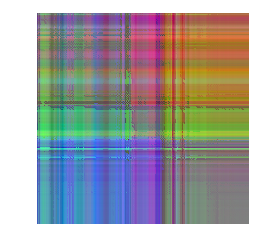

In [95]:
#get CAM
model_cam.eval()
test_img = np.asarray(Image.open(DATADIR + 'val/' + img).convert('RGB'))
plt.figure()
plt.axis('off')
plt.imshow(test_img)
test_img = test_img.astype(np.float32)
test_img = test_img/255.0
test_img = test_img.transpose((2,0,1))
test_tensor = torch.from_numpy(test_img)
output = model_cam(torch.autograd.Variable(torch.unsqueeze(test_tensor, 0).cuda()))
features = output[0].cpu().detach().numpy()
w = model.state_dict()['lr1.weight'].cpu().numpy()
w.shape
cam = np.zeros((28,28)).astype(float)
for i in range(32):
    cam += max(0,w[0][i])*features[i]
    #cam += w[0][i]*features[i]

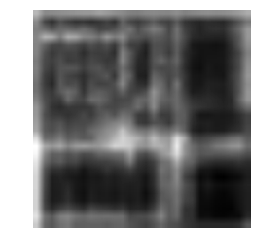

In [96]:
import scipy
unsample_cam = scipy.misc.imresize(cam, (224,224))

unsample_cam -= np.min(unsample_cam)
unsample_cam = unsample_cam.astype(float)
unsample_cam /= np.max(unsample_cam)
plt.axis('off')
plt.imshow(unsample_cam*255, cmap = 'gray')

In [18]:
import time
start = time.clock()
result_list = []
for test_img in input_test:
    result_list.append(GetPredict(test_img))
elapsed = (time.clock() - start)
print("Time used:",elapsed)

('Time used:', 6.550933000000001)


In [15]:
cm = confusion_matrix(target_test, result_list)
print cm
normalized_cm = np.zeros((5,5))
for i in range(5):
    for j in range(5):
        normalized_cm[i][j] = float(cm[i][j])/sum(cm[i])
print normalized_cm

[[ 48   2   0   2   2]
 [  0  57   0   1   0]
 [  1   0  46   1   1]
 [  0   0   0 113   1]
 [  2   0   2   0  57]]
[[0.88888889 0.03703704 0.         0.03703704 0.03703704]
 [0.         0.98275862 0.         0.01724138 0.        ]
 [0.02040816 0.         0.93877551 0.02040816 0.02040816]
 [0.         0.         0.         0.99122807 0.00877193]
 [0.03278689 0.         0.03278689 0.         0.93442623]]
